# Introduction

This notebook is a port to pymc3 of the example given in the Metrum Institutes MI250: Introduction to Bayesian PK-PD Modelling and Simulation(2010) Lab1 session.

It illustrates the ease with which Bayesian models can be created and analysed with pymc3.

It utilises a very simple linear regression model as described in the youtube video, that can be found here...

https://www.youtube.com/watch?v=ozbQ9MtKuj4

other acknowledgements go to Jonathan Sedar for his pymc3 blog posts 

http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/

From which I used some code to draw the posterior predictive check function

### Import the required modules and set matplotlib to plot in the notebook

In [62]:
from pymc3 import Model, Normal, Uniform, NUTS, sample, find_MAP, traceplot, summary, df_summary, trace_to_dataframe
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

### Create dataset and plot

In [85]:
x = np.array([1,2,3,4,5,6,7,8,9,10])
y =np.array([5.19, 6.56, 9.19, 8.09, 7.6, 7.08, 6.74, 9.3, 9.98, 11.5])
df = pd.DataFrame({'x':x, 'y':y})

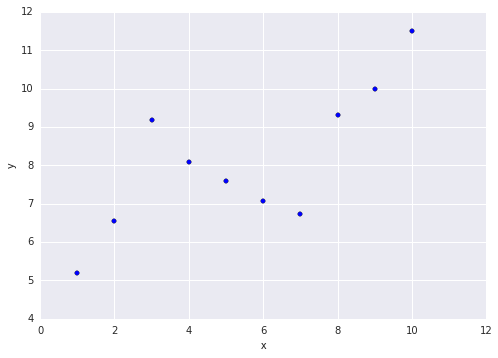

In [86]:
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')

### Create the model

pymc3 follows a standard structure for model creation.

1. create an instance of the model
2. with that model, assign the priors, the expected outcome and then the Likelihood distribution of the expected values

In [14]:
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=100)
    beta = Normal('beta', mu=0, sd=100)
    sigma = Uniform('sigma', lower=0, upper=10000)

    # Expected value of outcome
    mu = alpha + beta*x 

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=y)

Applied interval-transform to sigma and added transformed sigma_interval to model.


### Priors....

In [51]:
#find_MAP can be used to establish a useful starting point for the sampling
map_estimate = find_MAP(model=basic_model)

print(map_estimate)

{'alpha': array(5.565604646996525), 'beta': array(0.4649653674889776), 'sigma_interval': array(-8.994136456596895)}


### Find and assign the priors, then perform MCMC using the NUT sampler for 2000 iterations

In [16]:
import scipy

with basic_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=scipy.optimize.fmin_powell)

    # draw 2000 posterior samples
    trace = sample(2000, start=start) 

Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_interval
 [-----------------100%-----------------] 2000 of 2000 complete in 28.1 sec

### Inspect the traces

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b875a10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11bf3aa10>]], dtype=object)

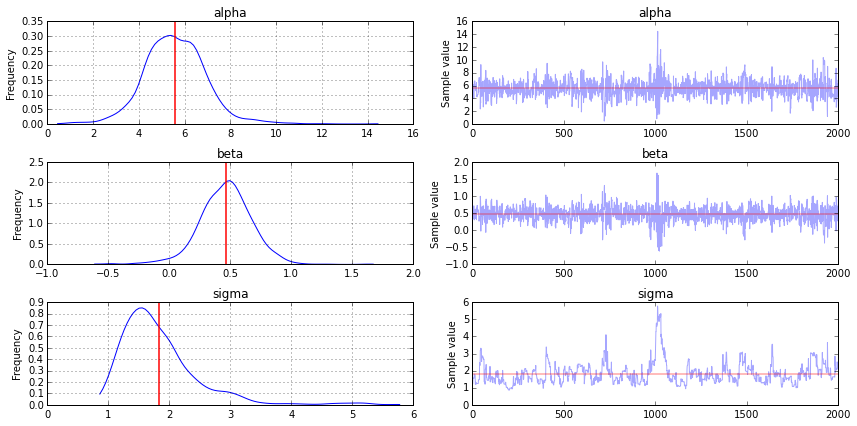

In [49]:
traceplot(trace, lines={k: v['mean'] for k, v in df_summary(trace).iterrows()})

In [50]:
summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.592            1.345            0.047            [2.704, 7.982]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.006          4.723          5.540          6.411          8.385


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.463            0.217            0.008            [0.078, 0.919]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.002          0.333          0.469          0.595          0.870


sigma:

  Mean             SD               MC Error         95% HPD interval
  --------------------------

In [45]:
df_summary(trace, alpha =0.1)

,mean,sd,mc_error,hpd_5,hpd_95
alpha,5.592174,1.34486,0.047396,3.451605,7.566117
beta,0.462638,0.21666,0.007542,0.126151,0.797009
sigma,1.828027,0.64945,0.057293,0.935136,2.615189


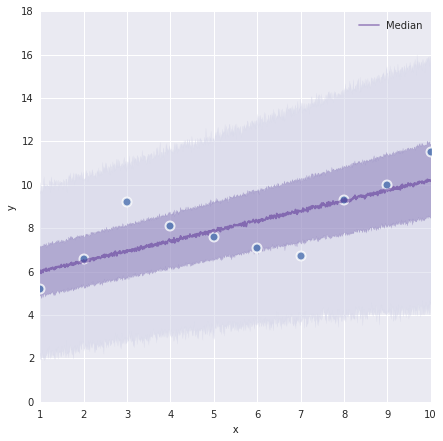

In [156]:
def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = trace_to_dataframe(trc)[['alpha','beta']]
    trc_sd = trace_to_dataframe(trc)['sigma']

    
    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.array([0, 1])
    like_mu = np.dot(X,trc_mu.T) + trc_mu.median()['alpha']
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10  
                 ,df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(basic_model, trace, df, xlims)